In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import copy
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
cpu = torch.device('cpu')#"cuda:0" if torch.cuda.is_available() else "cpu")
dv=torch.device('cuda')#torch.device("cuda" if torch.cuda.is_available() else "cpu")import torchmetrics
import torchmetrics
acc = torchmetrics.Accuracy(task="multiclass", num_classes=2)

In [2]:
from load_celebA import load_celeba

In [ ]:
import torchvision.models as pretrain
model_pre=pretrain.resnet18(pretrained=True)

In [4]:
for par in model_pre.parameters():
    par.requires_grad=False


In [3]:
from model_class import MTL_vission,Branched_model_vission
from my_util import DM_rate, branches,fair_loss,find_groups,sim_mat,Update_model

In [15]:
dt,yt, gt, d_v, yv, gv, dataloader_test, y_test, g_test,batch_size=load_celeba(protected='Age')                                                                             
N_tasks=len(y_test)

#CHANGE TO protected='Gender' for experiments on CelebA-Gender

In [8]:
shapes=[1024,128,256,512,128,64,256,128]
depth=len(shapes)-1
l2g_fmt=MTL_vission(pretrain=model_pre,tasks=N_tasks,shapes=shapes)
#l2g_fmt=nn.DataParallel(l2g_fmt)
l2g_fmt.to(dv)
opti_S=optim.AdamW(params=l2g_fmt.parameters())

In [16]:
path='/yourpath/models/g_fbage.pt'
path_br='/yourpath/models/gfba_branches.pt'
path_task='/yourpath/models/gfba_task_layers.pt'
path_sh='/yourpath/models/gfba_sh_layers.pt'
path_par='/yourpath/models/gfba_parents.pt'
path_pre='/yourpath/models/gfba_pretrain.pt'

In [9]:

parents={i:[] for i in range(N_tasks)}
out=1
branch_layers=nn.ModuleDict()
omega_S=torch.tensor([1/N_tasks for t in range(N_tasks)]).to(dv)
groups=[[i for i in range(N_tasks)]]
init_loss_S=[None for t in range(N_tasks)]
lossa_p=[torch.tensor(0.0001) for t in range(N_tasks)]
lossf_p=[torch.tensor(0.0001) for t in range(N_tasks)]
criteria = nn.CrossEntropyLoss()
train_losses_a=[[] for i in range(N_tasks)]
train_losses_f=[[] for i in range(N_tasks)]
Val_accuray=[[] for i in range(N_tasks)]
Val_fairness=[[] for i in range(N_tasks)]


for epoch in range(50):  # loop over each NN multiple times
    ch=np.random.choice([0,1,2,3])
    dataloader,y_train,g_train=dt[ch],yt[ch],gt[ch]
    y_train=[torch.tensor(y_train[i]) for i in range(N_tasks)]
    xg=torch.tensor(g_train)
    l2g_fmt.to(dv)
    for i, data in enumerate(dataloader):
        inputs =data[0]
        if ((i+1)*batch_size)<len(g_train):            
            labels=[y_train[t][i*batch_size:(i+1)*batch_size] for t in range(N_tasks)]
            xc=xg[i*batch_size:(i+1)*batch_size]
        else:
            labels=[y_train[t][i*batch_size:] for t in range(N_tasks)]
            xc=xg[i*batch_size:]
        
        
        # zero the parameter gradients
        #net.load_state_dict(torch.load(path))  
        
        opti_S.zero_grad()
        outputs = l2g_fmt(inputs.to(dv).float())
        lp,grads,G_n,loss_ratio=[0 for t in range(N_tasks)],[],[],[]
        for t in range(N_tasks):
            loss_a=criteria(outputs[t], labels[t].to(dv))
            loss_f=fair_loss(outputs[t], labels[t].to(dv),xc.to(dv))
            c_a=(loss_a.item()-lossa_p[t])/lossa_p[t]
            c_f=(loss_f.item()-lossf_p[t])/lossf_p[t]
            #print(c_a,c_f)
            #for training with summed loss replace the if else block with loss=loss_a+loss_f
            if c_a > c_f:
                loss=loss_a
                #print('accuracy','--',t)
            else:
                loss=loss_f
                #print('fairness','--',t)
            
            loss.backward(retain_graph=True)
            if epoch<=14:
                lossa_p[t]=loss_a.item()
                lossf_p[t]=loss_f.item()
                loss.backward(retain_graph=True)
                if init_loss_S[t]== None:
                    init_loss_S[t]=loss.item()
                loss_ratio.append(loss.item()/init_loss_S[t])
                grads_sh={}
                for n,p in l2g_fmt.named_parameters():
                    if p.data.shape[0]!=2 and p.grad!=None:
                        grads_sh[n] = p.grad
                        p.grad=None
                        #p.grad.zero_()
                grads.append(grads_sh)
                G_n.append(torch.linalg.norm(torch.stack([torch.linalg.norm(grads_sh[g]) for g in grads_sh])))
                train_losses_a[t].append(loss_a.to(cpu).item())
                train_losses_f[t].append(loss_f.to(cpu).item())
        if epoch<=14:
            G_n = torch.stack(G_n)
            E_t = sum(loss_ratio)/len(loss_ratio)
            r_t=[loss/E_t for loss in loss_ratio] #relative inverse trainin g rate of student
            omega_S,l2g_fmt = Update_model(l2g_fmt,grads,omega_S,G_n,r_t,opti_S,parents) 
            torch.save(l2g_fmt.state_dict(),path)
        else:
            opti_S.step()
    cka_scores=sim_mat(l2g_fmt,out)
    gps=find_groups(cka_scores)
    if epoch%5==0 and epoch>0 and out<=depth and len(gps)>=2:   
        groups=copy.deepcopy(gps)
        embeddor,shared_layers,branch_layers,task_layers,parents=branches(l2g_fmt,groups,out,parents,
                                                                          branch_layers,premod=True)
        del l2g_fmt
        l2g_fmt=Branched_model_vission(pretrain=embeddor,shared_all=shared_layers.to(cpu),branches=branch_layers.to(cpu),
                               task_layers=task_layers.to(cpu),parents=parents,device=dv)
        #l2g_fmt=nn.DataParallel(l2g_fmt)
        torch.save(branch_layers,path_br)
        torch.save(task_layers,path_task)
        torch.save(shared_layers,path_sh)
        torch.save(parents,path_par)
        torch.save(embeddor,path_pre)
        l2g_fmt.to(dv)
        opti_S=optim.AdamW(params=l2g_fmt.parameters())
        out+=1
    with torch.no_grad():
        ch=np.random.choice([0,1])
        val_batch,y_v,g_val=next(iter(d_v[ch]))[0],yv[ch],gv[ch]
        l2g_fmt.to(dv)
        torch.save(l2g_fmt.state_dict(),path)
        pred0=l2g_fmt(val_batch.to(dv))
        print('Epoch: ',epoch, 'Possible groups:', gps, 'at Layer', out)
        #print(cka_scores)
        for t in range(N_tasks):            
            accuracy=acc(pred0[t].to(cpu),torch.tensor(y_v[t]))
            EO=DM_rate(pred0[t].to(cpu),torch.tensor(y_v[t]).to(cpu),torch.tensor(g_val).to(cpu))  
            print('Task',t,'  Acc:',accuracy, 'EO:',EO)
        

Epoch:  0 Possible groups: [[0, 23], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13, 16], [14], [15], [17], [18, 29], [19], [20], [21], [22], [24], [25], [26], [27], [28], [30]] at Layer 1
Task 0   Acc: tensor(0.8833) EO: (tensor(0.0134), tensor(0.0039))
Task 1   Acc: tensor(0.7425) EO: (tensor(0.0082), tensor(0.0072))
Task 2   Acc: tensor(0.4794) EO: (tensor(0.0292), tensor(0.0195))
Task 3   Acc: tensor(0.7890) EO: (tensor(0.0090), tensor(0.0065))
Task 4   Acc: tensor(0.8506) EO: (tensor(0.0202), tensor(0.0136))
Task 5   Acc: tensor(0.8484) EO: (tensor(0.0343), tensor(0.0314))
Task 6   Acc: tensor(0.7483) EO: (tensor(0.0201), tensor(0.0175))
Task 7   Acc: tensor(0.7930) EO: (tensor(0.0265), tensor(0.0154))
Task 8   Acc: tensor(0.8496) EO: (tensor(0.0115), tensor(0.0105))
Task 9   Acc: tensor(0.7575) EO: (tensor(0.0398), tensor(0.0259))
Task 10   Acc: tensor(0.8591) EO: (tensor(0.0118), tensor(0.0020))
Task 11   Acc: tensor(0.9296) EO: (tensor(0.0216), tensor(0.0134

Task 20   Acc: tensor(0.7170) EO: (tensor(0.0091), tensor(0.0004))
Task 21   Acc: tensor(0.7166) EO: (tensor(0.0133), tensor(0.0093))
Task 22   Acc: tensor(0.9284) EO: (tensor(0.0088), tensor(0.0058))
Task 23   Acc: tensor(0.9315) EO: (tensor(0.0151), tensor(0.0109))
Task 24   Acc: tensor(0.5934) EO: (tensor(0.0277), tensor(0.0132))
Task 25   Acc: tensor(0.7982) EO: (tensor(0.0250), tensor(0.0149))
Task 26   Acc: tensor(0.7231) EO: (tensor(0.0111), tensor(0.0100))
Task 27   Acc: tensor(0.8066) EO: (tensor(0.0537), tensor(0.0479))
Task 28   Acc: tensor(0.7009) EO: (tensor(0.0199), tensor(0.0160))
Task 29   Acc: tensor(0.8790) EO: (tensor(0.0330), tensor(0.0311))
Task 30   Acc: tensor(0.9274) EO: (tensor(0.0290), tensor(0.0264))
Epoch:  4 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9, 25], [10], [11], [12], [13, 26], [14], [15], [16, 24], [17], [18], [19], [20], [21], [22], [23, 30], [27], [28], [29]] at Layer 1
Task 0   Acc: tensor(0.8806) EO: (tensor(0.0076), tensor

Task 12   Acc: tensor(0.9251) EO: (tensor(0.0047), tensor(0.0021))
Task 13   Acc: tensor(0.7674) EO: (tensor(0.0195), tensor(0.0164))
Task 14   Acc: tensor(0.6289) EO: (tensor(0.0199), tensor(0.0147))
Task 15   Acc: tensor(0.7856) EO: (tensor(0.0044), tensor(0.0037))
Task 16   Acc: tensor(0.5563) EO: (tensor(0.0429), tensor(0.0186))
Task 17   Acc: tensor(0.9469) EO: (tensor(0.0037), tensor(0.0034))
Task 18   Acc: tensor(0.9227) EO: (tensor(0.0220), tensor(0.0188))
Task 19   Acc: tensor(0.8201) EO: (tensor(0.0170), tensor(0.0046))
Task 20   Acc: tensor(0.7155) EO: (tensor(0.0133), tensor(0.0056))
Task 21   Acc: tensor(0.7166) EO: (tensor(0.0133), tensor(0.0093))
Task 22   Acc: tensor(0.9284) EO: (tensor(0.0088), tensor(0.0058))
Task 23   Acc: tensor(0.9315) EO: (tensor(0.0151), tensor(0.0109))
Task 24   Acc: tensor(0.6063) EO: (tensor(0.0076), tensor(0.0023))
Task 25   Acc: tensor(0.7982) EO: (tensor(0.0250), tensor(0.0149))
Task 26   Acc: tensor(0.7053) EO: (tensor(0.0463), tensor(0.03

Epoch:  12 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17, 18], [19], [20], [21]] at Layer 3
Task 0   Acc: tensor(0.8833) EO: (tensor(0.0133), tensor(0.0039))
Task 1   Acc: tensor(0.7467) EO: (tensor(0.0171), tensor(0.0168))
Task 2   Acc: tensor(0.6599) EO: (tensor(0.0389), tensor(0.0200))
Task 3   Acc: tensor(0.7893) EO: (tensor(0.0156), tensor(0.0119))
Task 4   Acc: tensor(0.8506) EO: (tensor(0.0202), tensor(0.0136))
Task 5   Acc: tensor(0.8484) EO: (tensor(0.0343), tensor(0.0314))
Task 6   Acc: tensor(0.7545) EO: (tensor(0.0220), tensor(0.0213))
Task 7   Acc: tensor(0.7921) EO: (tensor(0.0245), tensor(0.0137))
Task 8   Acc: tensor(0.8490) EO: (tensor(0.0108), tensor(0.0096))
Task 9   Acc: tensor(0.7585) EO: (tensor(0.0391), tensor(0.0269))
Task 10   Acc: tensor(0.8591) EO: (tensor(0.0118), tensor(0.0020))
Task 11   Acc: tensor(0.9297) EO: (tensor(0.0217), tensor(0.0134))
Task 12   Acc: tensor(0.9249) EO: (tensor(0.00

Epoch:  16 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18, 19]] at Layer 4
Task 0   Acc: tensor(0.8807) EO: (tensor(0.0074), tensor(0.0067))
Task 1   Acc: tensor(0.7520) EO: (tensor(0.0215), tensor(0.0106))
Task 2   Acc: tensor(0.6718) EO: (tensor(0.0085), tensor(0.0031))
Task 3   Acc: tensor(0.7961) EO: (tensor(0.0128), tensor(0.0011))
Task 4   Acc: tensor(0.8560) EO: (tensor(0.0428), tensor(0.0370))
Task 5   Acc: tensor(0.8451) EO: (tensor(0.0201), tensor(0.0166))
Task 6   Acc: tensor(0.7664) EO: (tensor(0.0337), tensor(0.0295))
Task 7   Acc: tensor(0.8078) EO: (tensor(0.0208), tensor(0.0204))
Task 8   Acc: tensor(0.8495) EO: (tensor(0.0407), tensor(0.0302))
Task 9   Acc: tensor(0.7618) EO: (tensor(0.0438), tensor(0.0299))
Task 10   Acc: tensor(0.8563) EO: (tensor(0.0179), tensor(0.0173))
Task 11   Acc: tensor(0.9311) EO: (tensor(0.0155), tensor(0.0128))
Task 12   Acc: tensor(0.9275) EO: (tensor(0.0439), tensor(

Epoch:  20 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18, 19]] at Layer 5
Task 0   Acc: tensor(0.8807) EO: (tensor(0.0074), tensor(0.0067))
Task 1   Acc: tensor(0.7552) EO: (tensor(0.0262), tensor(0.0235))
Task 2   Acc: tensor(0.6962) EO: (tensor(0.0101), tensor(0.0100))
Task 3   Acc: tensor(0.7943) EO: (tensor(0.0166), tensor(0.0060))
Task 4   Acc: tensor(0.8560) EO: (tensor(0.0428), tensor(0.0370))
Task 5   Acc: tensor(0.8476) EO: (tensor(0.0144), tensor(0.0120))
Task 6   Acc: tensor(0.7722) EO: (tensor(0.0279), tensor(0.0229))
Task 7   Acc: tensor(0.8118) EO: (tensor(0.0207), tensor(0.0133))
Task 8   Acc: tensor(0.8996) EO: (tensor(0.0047), tensor(0.0030))
Task 9   Acc: tensor(0.7683) EO: (tensor(0.0479), tensor(0.0345))
Task 10   Acc: tensor(0.8584) EO: (tensor(0.0142), tensor(0.0113))
Task 11   Acc: tensor(0.9313) EO: (tensor(0.0170), tensor(0.0150))
Task 12   Acc: tensor(0.9273) EO: (tensor(0.0441), tensor(

Epoch:  24 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16, 17], [18]] at Layer 5
Task 0   Acc: tensor(0.8835) EO: (tensor(0.0137), tensor(0.0039))
Task 1   Acc: tensor(0.7622) EO: (tensor(0.0120), tensor(0.0115))
Task 2   Acc: tensor(0.6866) EO: (tensor(0.0384), tensor(0.0122))
Task 3   Acc: tensor(0.7901) EO: (tensor(0.0028), tensor(0.0006))
Task 4   Acc: tensor(0.8564) EO: (tensor(0.0294), tensor(0.0183))
Task 5   Acc: tensor(0.8508) EO: (tensor(0.0421), tensor(0.0400))
Task 6   Acc: tensor(0.7647) EO: (tensor(0.0435), tensor(0.0355))
Task 7   Acc: tensor(0.8253) EO: (tensor(0.0142), tensor(0.0084))
Task 8   Acc: tensor(0.9050) EO: (tensor(0.0591), tensor(0.0562))
Task 9   Acc: tensor(0.7768) EO: (tensor(0.0192), tensor(0.0138))
Task 10   Acc: tensor(0.8644) EO: (tensor(0.0106), tensor(0.0020))
Task 11   Acc: tensor(0.9303) EO: (tensor(0.0317), tensor(0.0218))
Task 12   Acc: tensor(0.9251) EO: (tensor(0.0047), tensor(0.0021

Epoch:  28 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11, 17], [12], [13], [14], [15], [16]] at Layer 6
Task 0   Acc: tensor(0.8823) EO: (tensor(0.0072), tensor(0.0067))
Task 1   Acc: tensor(0.7536) EO: (tensor(0.0173), tensor(0.0045))
Task 2   Acc: tensor(0.7025) EO: (tensor(0.0320), tensor(0.0171))
Task 3   Acc: tensor(0.7957) EO: (tensor(0.0156), tensor(0.0028))
Task 4   Acc: tensor(0.8744) EO: (tensor(0.0570), tensor(0.0461))
Task 5   Acc: tensor(0.8476) EO: (tensor(0.0303), tensor(0.0242))
Task 6   Acc: tensor(0.7735) EO: (tensor(0.0320), tensor(0.0270))
Task 7   Acc: tensor(0.8218) EO: (tensor(0.0130), tensor(0.0039))
Task 8   Acc: tensor(0.9066) EO: (tensor(0.0121), tensor(0.0118))
Task 9   Acc: tensor(0.7788) EO: (tensor(0.0267), tensor(0.0143))
Task 10   Acc: tensor(0.8625) EO: (tensor(0.0147), tensor(0.0124))
Task 11   Acc: tensor(0.9340) EO: (tensor(0.0115), tensor(0.0085))
Task 12   Acc: tensor(0.9268) EO: (tensor(0.0483), tensor(0.0441))
Tas

Epoch:  32 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12, 13], [14], [15], [16]] at Layer 7
Task 0   Acc: tensor(0.8837) EO: (tensor(0.0130), tensor(0.0039))
Task 1   Acc: tensor(0.7631) EO: (tensor(0.0173), tensor(0.0136))
Task 2   Acc: tensor(0.6912) EO: (tensor(0.0275), tensor(0.0037))
Task 3   Acc: tensor(0.7906) EO: (tensor(0.0111), tensor(0.0060))
Task 4   Acc: tensor(0.8727) EO: (tensor(0.0187), tensor(0.0179))
Task 5   Acc: tensor(0.8509) EO: (tensor(0.0348), tensor(0.0314))
Task 6   Acc: tensor(0.7677) EO: (tensor(0.0368), tensor(0.0299))
Task 7   Acc: tensor(0.8328) EO: (tensor(0.0141), tensor(0.0129))
Task 8   Acc: tensor(0.9106) EO: (tensor(0.0498), tensor(0.0463))
Task 9   Acc: tensor(0.7797) EO: (tensor(0.0069), tensor(0.0013))
Task 10   Acc: tensor(0.8640) EO: (tensor(0.0227), tensor(0.0104))
Task 11   Acc: tensor(0.9335) EO: (tensor(0.0204), tensor(0.0136))
Task 12   Acc: tensor(0.9268) EO: (tensor(0.0110), tensor(0.0078))
Task 13  

Epoch:  36 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12, 13], [14], [15]] at Layer 8
Task 0   Acc: tensor(0.8830) EO: (tensor(0.0201), tensor(0.0187))
Task 1   Acc: tensor(0.7600) EO: (tensor(0.0241), tensor(0.0127))
Task 2   Acc: tensor(0.7038) EO: (tensor(0.0168), tensor(0.0104))
Task 3   Acc: tensor(0.7957) EO: (tensor(0.0133), tensor(0.0015))
Task 4   Acc: tensor(0.8698) EO: (tensor(0.0475), tensor(0.0359))
Task 5   Acc: tensor(0.8464) EO: (tensor(0.0228), tensor(0.0181))
Task 6   Acc: tensor(0.7701) EO: (tensor(0.0194), tensor(0.0114))
Task 7   Acc: tensor(0.8204) EO: (tensor(0.0047), tensor(0.0018))
Task 8   Acc: tensor(0.9062) EO: (tensor(0.0070), tensor(0.0042))
Task 9   Acc: tensor(0.7794) EO: (tensor(0.0112), tensor(0.0009))
Task 10   Acc: tensor(0.8600) EO: (tensor(0.0051), tensor(0.0024))
Task 11   Acc: tensor(0.9344) EO: (tensor(0.0081), tensor(0.0039))
Task 12   Acc: tensor(0.9259) EO: (tensor(0.0415), tensor(0.0407))
Task 13   Acc: 

Epoch:  40 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12, 13], [14], [15]] at Layer 8
Task 0   Acc: tensor(0.8875) EO: (tensor(0.0250), tensor(0.0138))
Task 1   Acc: tensor(0.7579) EO: (tensor(0.0050), tensor(0.0023))
Task 2   Acc: tensor(0.6918) EO: (tensor(0.0343), tensor(0.0108))
Task 3   Acc: tensor(0.7894) EO: (tensor(0.0042), tensor(0.0027))
Task 4   Acc: tensor(0.8711) EO: (tensor(0.0033), tensor(0.0022))
Task 5   Acc: tensor(0.8510) EO: (tensor(0.0518), tensor(0.0509))
Task 6   Acc: tensor(0.7653) EO: (tensor(0.0359), tensor(0.0241))
Task 7   Acc: tensor(0.8277) EO: (tensor(0.0043), tensor(0.0031))
Task 8   Acc: tensor(0.9077) EO: (tensor(0.0546), tensor(0.0521))
Task 9   Acc: tensor(0.7788) EO: (tensor(0.0156), tensor(0.0126))
Task 10   Acc: tensor(0.8597) EO: (tensor(0.0269), tensor(0.0153))
Task 11   Acc: tensor(0.9331) EO: (tensor(0.0114), tensor(0.0033))
Task 12   Acc: tensor(0.9260) EO: (tensor(0.0078), tensor(0.0053))
Task 13   Acc: 

Epoch:  44 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12, 13], [14], [15]] at Layer 8
Task 0   Acc: tensor(0.8851) EO: (tensor(0.0243), tensor(0.0138))
Task 1   Acc: tensor(0.7638) EO: (tensor(0.0163), tensor(0.0124))
Task 2   Acc: tensor(0.6993) EO: (tensor(0.0155), tensor(0.0023))
Task 3   Acc: tensor(0.7914) EO: (tensor(0.0014), tensor(0.0002))
Task 4   Acc: tensor(0.8755) EO: (tensor(0.0326), tensor(0.0293))
Task 5   Acc: tensor(0.8496) EO: (tensor(0.0432), tensor(0.0419))
Task 6   Acc: tensor(0.7696) EO: (tensor(0.0400), tensor(0.0326))
Task 7   Acc: tensor(0.8358) EO: (tensor(0.0070), tensor(0.0055))
Task 8   Acc: tensor(0.9105) EO: (tensor(0.0537), tensor(0.0510))
Task 9   Acc: tensor(0.7801) EO: (tensor(0.0132), tensor(0.0049))
Task 10   Acc: tensor(0.8622) EO: (tensor(0.0201), tensor(0.0095))
Task 11   Acc: tensor(0.9328) EO: (tensor(0.0163), tensor(0.0055))
Task 12   Acc: tensor(0.9254) EO: (tensor(0.0026), tensor(0.0004))
Task 13   Acc: 

Epoch:  48 Possible groups: [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12, 13], [14], [15]] at Layer 8
Task 0   Acc: tensor(0.8814) EO: (tensor(0.0083), tensor(0.0077))
Task 1   Acc: tensor(0.7570) EO: (tensor(0.0199), tensor(0.0027))
Task 2   Acc: tensor(0.7032) EO: (tensor(0.0130), tensor(0.0116))
Task 3   Acc: tensor(0.7953) EO: (tensor(0.0138), tensor(0.0050))
Task 4   Acc: tensor(0.8800) EO: (tensor(0.0655), tensor(0.0564))
Task 5   Acc: tensor(0.8475) EO: (tensor(0.0290), tensor(0.0250))
Task 6   Acc: tensor(0.7783) EO: (tensor(0.0318), tensor(0.0306))
Task 7   Acc: tensor(0.8254) EO: (tensor(0.0205), tensor(0.0170))
Task 8   Acc: tensor(0.9077) EO: (tensor(0.0104), tensor(0.0066))
Task 9   Acc: tensor(0.7753) EO: (tensor(0.0255), tensor(0.0165))
Task 10   Acc: tensor(0.8634) EO: (tensor(0.0018), tensor(0.0008))
Task 11   Acc: tensor(0.9372) EO: (tensor(0.0124), tensor(0.0063))
Task 12   Acc: tensor(0.9288) EO: (tensor(0.0437), tensor(0.0407))
Task 13   Acc: 

In [17]:
embeddor,parents= torch.load(path_pre).to(dv),torch.load(path_par)
shared_layers,branch_layers,task_layers=torch.load(path_sh),torch.load(path_br),torch.load(path_task)

In [7]:
l2g_fmt.load_state_dict(torch.load(path))
l2g_fmt.to(dv)

Branched_model_vission(
  (pretrain): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine

In [14]:
dv2=torch.device('cuda:1')

In [21]:
test_batch=next(iter(dataloader_test))[0]

In [11]:
pred0=l2g_fmt(test_batch.to(dv).float())
test_acc=[]
test_fair=[]

for t in range(N_tasks):  
    accuracy=acc(pred0[t].to(cpu),torch.tensor(y_test[t]).to(cpu))
    DM=DM_rate(pred0[t].to(cpu),torch.tensor(y_test[t]).to(cpu),torch.tensor(g_test).to(cpu))
    test_acc.append(accuracy)
    test_fair.append(DM)  # this is a tupple of (EO, EP)
    print('Task',t,'  Acc:',accuracy, 'DMs:',DM)

Task 0   Acc: tensor(0.8956) DMs: (tensor(0.0415), tensor(0.0368))
Task 1   Acc: tensor(0.7349) DMs: (tensor(0.0139), tensor(0.0078))
Task 2   Acc: tensor(0.7075) DMs: (tensor(0.0077), tensor(0.0076))
Task 3   Acc: tensor(0.7913) DMs: (tensor(0.0172), tensor(0.0101))
Task 4   Acc: tensor(0.8754) DMs: (tensor(0.0110), tensor(0.0073))
Task 5   Acc: tensor(0.6814) DMs: (tensor(0.0050), tensor(8.8871e-05))
Task 6   Acc: tensor(0.7847) DMs: (tensor(0.0255), tensor(0.0239))
Task 7   Acc: tensor(0.7934) DMs: (tensor(0.0152), tensor(0.0107))
Task 8   Acc: tensor(0.9151) DMs: (tensor(0.0169), tensor(0.0158))
Task 9   Acc: tensor(0.8168) DMs: (tensor(0.0166), tensor(0.0083))
Task 10   Acc: tensor(0.8622) DMs: (tensor(0.0162), tensor(0.0114))
Task 11   Acc: tensor(0.9386) DMs: (tensor(0.0059), tensor(0.0053))
Task 12   Acc: tensor(0.9504) DMs: (tensor(0.0026), tensor(0.0019))
Task 13   Acc: tensor(0.7704) DMs: (tensor(0.0160), tensor(0.0043))
Task 14   Acc: tensor(0.6743) DMs: (tensor(0.0168), te

In [14]:
sacc=torch.load('/yourpath/age_sacc.pt') #load the accuracy of STLs you saved from STL notebook
sf=torch.load('/yourpath/age_sf.pt')     #load STL fairness
Ara=0
Areo=0
Arep=0
for t in range(N_tasks):
    Ara+=(test_acc[t])/sacc[t]
    Arep+=test_fair[t][1]/sf[t][1]
    Areo+=test_fair[t][0]/sf[t][0]
print(Ara/N_tasks)
print(Arep/N_tasks)
print(Areo/N_tasks)

tensor(1.0378)
tensor(4.7299)
tensor(1.1827)


In [15]:
print(sacc)
print(sf[:,0])
print(sf[:,1])

tensor([0.8661, 0.7240, 0.6777, 0.7454, 0.8500, 0.6408, 0.7424, 0.7763, 0.9034,
        0.7831, 0.8255, 0.9291, 0.9308, 0.7542, 0.6371, 0.8087, 0.5885, 0.9491,
        0.8108, 0.8194, 0.6466, 0.6602, 0.8944, 0.9356, 0.6376, 0.7482, 0.7252,
        0.7644, 0.7830, 0.8279, 0.9218])
tensor([0.0431, 0.0114, 0.0166, 0.0062, 0.0200, 0.0097, 0.0108, 0.0197, 0.0156,
        0.0143, 0.0122, 0.0137, 0.0133, 0.0166, 0.0125, 0.0107, 0.0303, 0.0027,
        0.0240, 0.0307, 0.0171, 0.0445, 0.0100, 0.0027, 0.0072, 0.0261, 0.0189,
        0.0034, 0.0055, 0.0148, 0.0423])
tensor([4.0828e-02, 9.6886e-03, 6.3961e-03, 5.0070e-03, 1.5809e-02, 2.8443e-04,
        3.3723e-03, 1.6836e-02, 1.4899e-02, 1.3432e-02, 9.5974e-03, 1.2379e-02,
        9.6510e-03, 1.3381e-02, 2.8931e-03, 9.4172e-03, 1.5241e-02, 2.2107e-03,
        2.1031e-02, 1.2338e-02, 9.3582e-03, 3.4519e-02, 9.4831e-05, 1.1039e-03,
        2.0315e-03, 2.1964e-02, 1.1710e-02, 1.5102e-03, 2.9589e-03, 1.3209e-02,
        3.8164e-02])


In [ ]:
#negative and unfair transfer
nta=[(test_acc[t]-sacc[t])*100 
       for t in range(N_tasks)]

utepa=[(test_fair[t][1]-sf[t][1])*100
       for t in range(N_tasks)]

uteoa=[(test_fair[t][0]-sf[t][0])*100 
       for t in range(N_tasks)]

In [ ]:
Ft=load_celeba(protected='Age',return_ft=True)

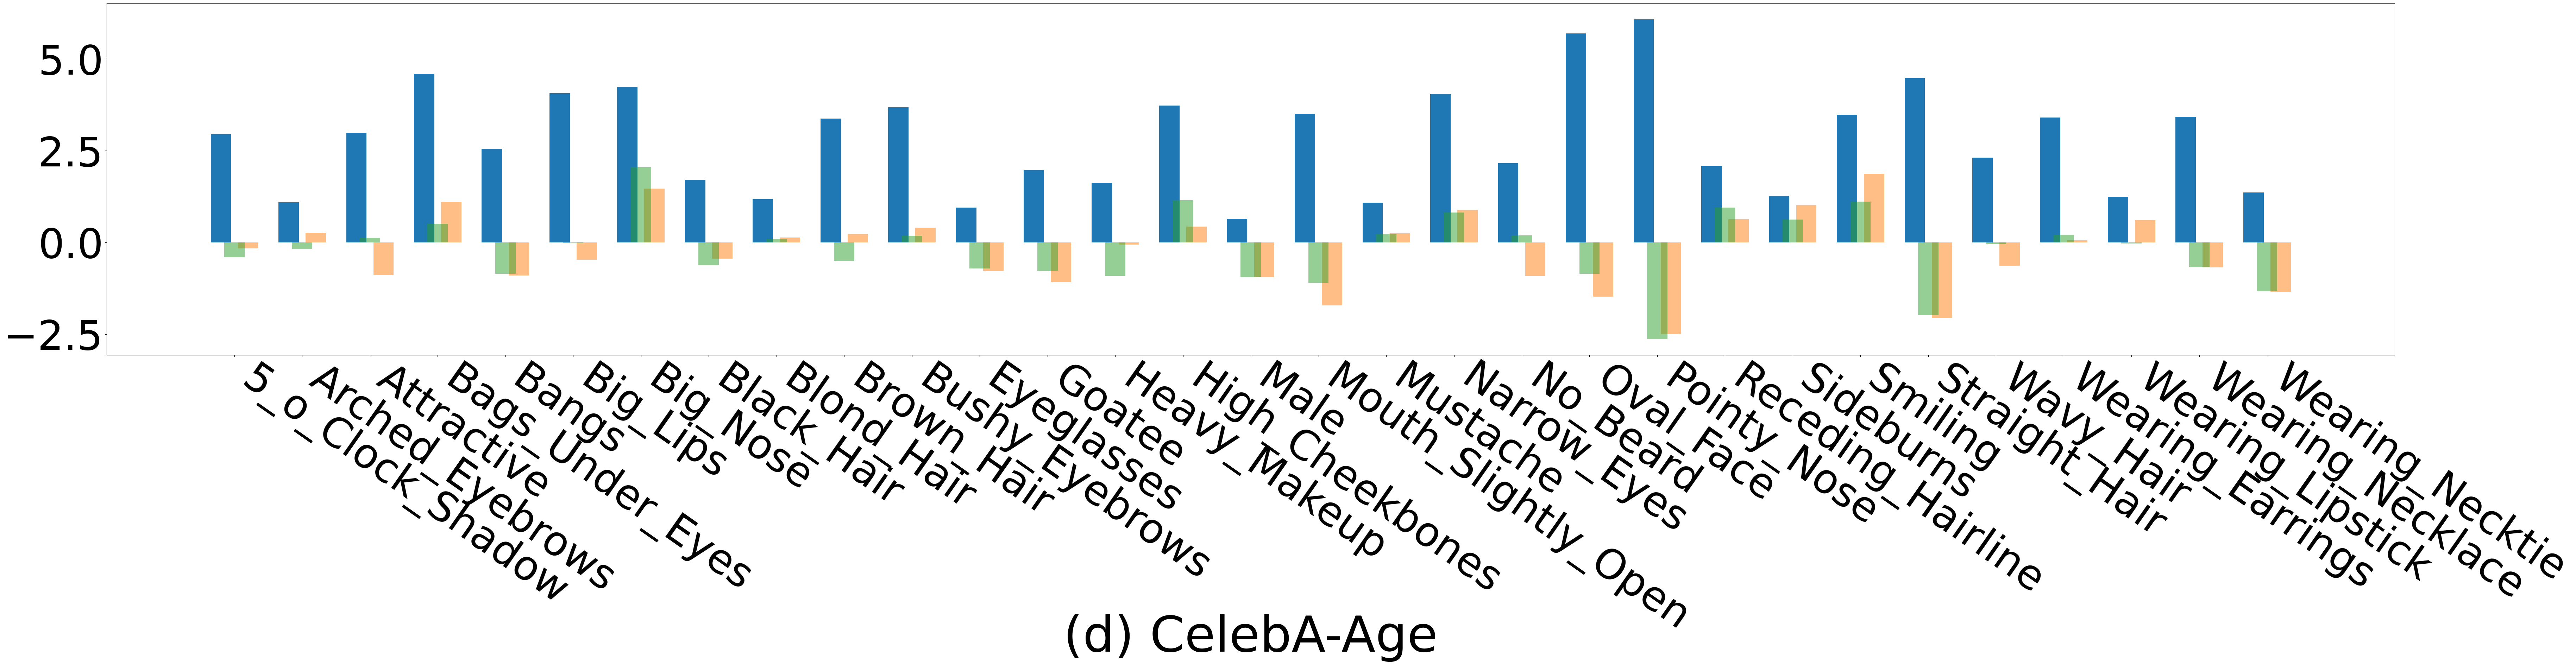

In [44]:
fig = plt.figure(figsize=(65,10))
plt.rcParams.update({'font.size': 84, 'font.stretch':'condensed'})
ax = fig.add_axes([0,0,1,1])
X_axis = np.arange(len(Ft))
ax.bar(X_axis-0.2,nta,width=0.3,label='Accuracy')
ax.bar(X_axis+0.2,uteoa,alpha=0.5,width=0.3,label='Equalized Odds')
ax.bar(Ft,utepa,alpha=0.5,width=0.3,label='Equal Opportunity')
ax.set_title('(d) CelebA-Age',y=-.85,fontsize=102)
plt.xticks(rotation=-35,ha='left')
ax3.set_ylim(-6,10)
#plt.legend(ncol=3)
plt.show()